In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4b4a287089fbb147cd419328be840b8f58494b1c5fae96139d2330a8a7648456
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,StandardScaler,StringIndexer,PCA,OneHotEncoder
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("Crime Analysis PCAbuilder")\
    .getOrCreate()
sc = spark.sparkContext

In [ ]:
df = spark.read.csv('drive/My Drive/cleaned_v3.csv',header = True,inferSchema = True)

In [ ]:
df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Agency_type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Crime_status: string (nullable = true)
 |-- Victim_age: integer (nullable = true)
 |-- Victim_sex: string (nullable = true)
 |-- Victim_race: string (nullable = true)
 |-- Offender_age: integer (nullable = true)
 |-- Offender_sex: string (nullable = true)
 |-- Offender_race: string (nullable = true)
 |-- Weapon: string (nullable = true)
 |-- Relationship: string (nullable = true)
 |-- Crime_cause: string (nullable = true)
 |-- add_victim_count: integer (nullable = true)
 |-- add_offender_count: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Offender_demo: string (nullable = true)



In [ ]:
df.columns

['State',
 'Agency_type',
 'Year',
 'Month',
 'Crime_type',
 'Crime_status',
 'Victim_age',
 'Victim_sex',
 'Victim_race',
 'Offender_age',
 'Offender_sex',
 'Offender_race',
 'Weapon',
 'Relationship',
 'Crime_cause',
 'add_victim_count',
 'add_offender_count',
 'County',
 'Offender_demo']

In [ ]:
# drop the target variable ,age and sex columns
df = df.drop('Offender_age','Offender_sex')

Transforming the categorical variables

In [ ]:
# Define the input and output column vectors
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
idxed_cols = ['%s_idx'%i for i in str_cols]
recoded_cols = ['%s_recoded'%i for i in str_cols]

In [ ]:
# Convert the categorical column of labels to a column of label indices
indexer = StringIndexer(inputCols=str_cols, outputCols=idxed_cols)
indexed = indexer.fit(df).transform(df)
#indexed.show()

In [ ]:
indexed.show()

+----------+----------------+----+-------+--------------------+--------------------+----------+----------+-----------+-------------+--------------------+--------------------+--------------------+----------------+------------------+-----------+-------------+---------+---------------+---------+--------------+----------------+--------------+---------------+-----------------+----------+----------------+---------------+----------+-----------------+
|     State|     Agency_type|Year|  Month|          Crime_type|        Crime_status|Victim_age|Victim_sex|Victim_race|Offender_race|              Weapon|        Relationship|         Crime_cause|add_victim_count|add_offender_count|     County|Offender_demo|State_idx|Agency_type_idx|Month_idx|Crime_type_idx|Crime_status_idx|Victim_sex_idx|Victim_race_idx|Offender_race_idx|Weapon_idx|Relationship_idx|Crime_cause_idx|County_idx|Offender_demo_idx|
+----------+----------------+----+-------+--------------------+--------------------+----------+---------

In [ ]:
# One hot encoding for categorical variables
encoder = OneHotEncoder(inputCols=idxed_cols,
                        outputCols=recoded_cols)
model = encoder.fit(indexed)
encoded = model.transform(indexed)
#encoded.show()

In [ ]:
# Drop the original catgorical columns and indexed columns before further proceed
encoded = encoded.drop(*str_cols)  # use * to convert unpacks the contents of an iterator

In [ ]:
encoded = encoded.drop(*idxed_cols)

In [ ]:
encoded.show()

+----+----------+----------------+------------------+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+
|Year|Victim_age|add_victim_count|add_offender_count|  State_recoded|Agency_type_recoded| Month_recoded|Crime_type_recoded|Crime_status_recoded|Victim_sex_recoded|Victim_race_recoded|Offender_race_recoded|Weapon_recoded|Relationship_recoded|Crime_cause_recoded|    County_recoded|Offender_demo_recoded|
+----+----------+----------------+------------------+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+
|2000|        25|               0|                 0|(50,[38],[1.0])|      (7,[0],[1.0])|(1

Scalling the numerical varibale - Standard scaler

In [ ]:
num_cols= ['Victim_age','Year','add_victim_count','add_offender_count']

In [ ]:
#df_cont = df[num_cols]
#df_cont.show()

In [ ]:
# Create the vector assembler to combine all input cols
vector_assembler = VectorAssembler(inputCols=num_cols, outputCol='cont_features')

In [ ]:
# Data Transformation using Standard Scaler
scaler = StandardScaler(inputCol='cont_features', outputCol='x_scaled',
                        withStd=True, withMean=True) # Normalize each feature to have unit standard deviation and zero mean

pipeline = Pipeline(stages=[vector_assembler, scaler])
scaler_model = pipeline.fit(encoded) # add the scaled features to the encoded dataset
scaled = scaler_model.transform(encoded)
scaled.show()

+----+----------+----------------+------------------+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+
|Year|Victim_age|add_victim_count|add_offender_count|  State_recoded|Agency_type_recoded| Month_recoded|Crime_type_recoded|Crime_status_recoded|Victim_sex_recoded|Victim_race_recoded|Offender_race_recoded|Weapon_recoded|Relationship_recoded|Crime_cause_recoded|    County_recoded|Offender_demo_recoded|       cont_features|            x_scaled|
+----+----------+----------------+------------------+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+--------

In [ ]:
# View the scaled vector for all the variables
scaled.select(['x_scaled']).collect()

[Row(x_scaled=DenseVector([-0.5227, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-0.5805, -1.7052, -0.2559, 0.876])),
 Row(x_scaled=DenseVector([-0.06, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-1.795, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([2.1955, -1.7052, -0.2559, 3.4089])),
 Row(x_scaled=DenseVector([0.4027, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-0.6962, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([0.981, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-0.1178, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([1.7329, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-0.6962, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-1.9107, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([1.6172, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-0.2335, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVector([-0.407, -1.7052, -0.2559, -0.3904])),
 Row(x_scaled=DenseVect

In [ ]:
# Drop the extra outputs num_cols and cont_features before PCA
scaled = scaled.drop('cont_features')

In [ ]:
scaled = scaled.drop(*num_cols)

In [ ]:
scaled.show()

+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+--------------------+
|  State_recoded|Agency_type_recoded| Month_recoded|Crime_type_recoded|Crime_status_recoded|Victim_sex_recoded|Victim_race_recoded|Offender_race_recoded|Weapon_recoded|Relationship_recoded|Crime_cause_recoded|    County_recoded|Offender_demo_recoded|            x_scaled|
+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+--------------------+
|(50,[38],[1.0])|      (7,[0],[1.0])|(11,[4],[1.0])|     (1,[0],[1.0])|       (5,[0],[1.0])|         (1,[],[])|      (2,[1],[1.0])|        (2,[1],[1.0])| (4,[0],[1.0])|       (4,[2],[1

Principle Component Analysis

In [ ]:
# Combined both sclaed numeric features and encoded categorical variables to be input into the PCA function
# Create the vector assembler to combine all input cols
vector_assembler = VectorAssembler(inputCols=scaled.columns, outputCol='inpca_features')
scaled_df = vector_assembler.transform(scaled)

In [ ]:
# Define the PCA with no of components and input data vectors
pca = PCA(k=10, inputCol="inpca_features", outputCol="features")

In [ ]:
# Fit data to the PC to obtained model
pca_model = pca.fit(scaled_df)

In [ ]:
transformed = pca_model.transform(scaled_df)
transformed.show(5)

+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+
|  State_recoded|Agency_type_recoded| Month_recoded|Crime_type_recoded|Crime_status_recoded|Victim_sex_recoded|Victim_race_recoded|Offender_race_recoded|Weapon_recoded|Relationship_recoded|Crime_cause_recoded|    County_recoded|Offender_demo_recoded|            x_scaled|      inpca_features|            features|
+---------------+-------------------+--------------+------------------+--------------------+------------------+-------------------+---------------------+--------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+
|(50,[38],[1.0])|      (7,[0],[1.0])|(11,[4],[1.0])|     (

In [ ]:
#transformed.select('features').show() # view a specific column
#transformed.select(['features']).collect() # view the data in rowwise

In [ ]:
# Explained variance per PC
print(pca_model.explainedVariance)

[0.11798932360617173,0.10073977457464915,0.09243639767062162,0.0880745366636902,0.06638279754079876,0.037410326889698774,0.033603343188356845,0.029046485728652,0.02455358398207598,0.022383033776370173]


Text(0, 0.5, 'percentage of Variance')

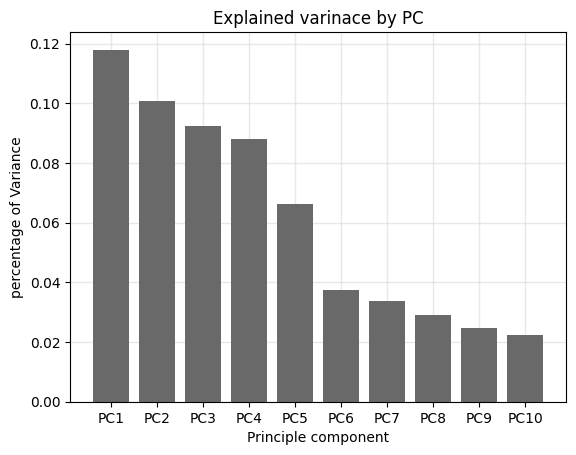

In [ ]:
# Plot the variance explained by each PC
pc = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
plt.bar(pc,pca_model.explainedVariance,color='dimgrey',alpha=1,zorder=2)
plt.grid(color='lightgrey', linewidth=1, axis='both', alpha=0.5)
plt.title("Explained varinace by PC")
plt.xlabel("Principle component")
plt.ylabel("percentage of Variance")

Text(0, 0.5, 'Cumulative PEV')

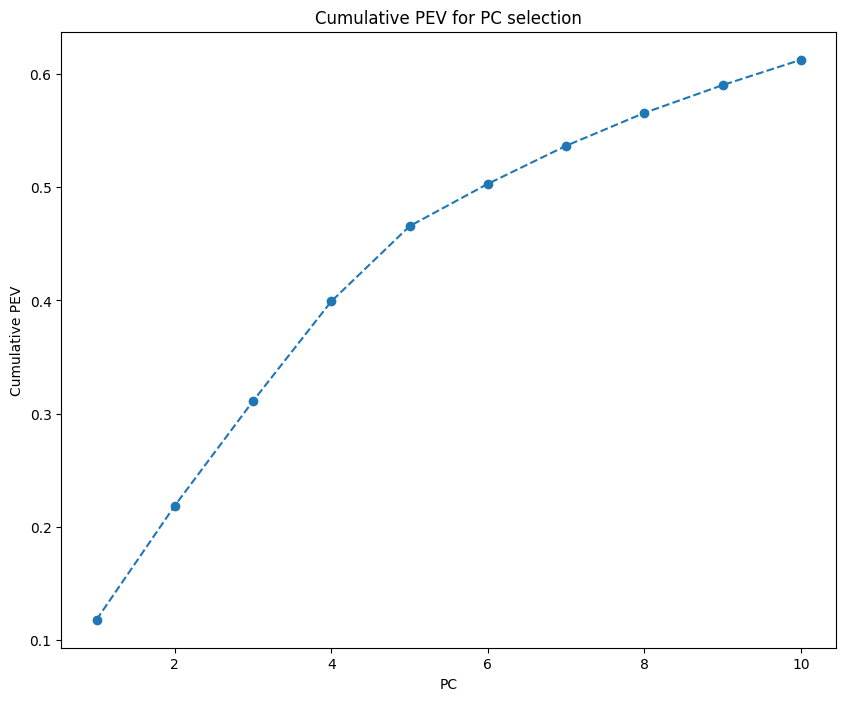

In [ ]:
# get the cumulative values
cumValues = pca_model.explainedVariance.cumsum()

# plot the graph
plt.figure(figsize=(10,8))
plt.plot(range(1,11), cumValues, marker = 'o', linestyle='--')
plt.title('Cumulative PEV for PC selection')
plt.xlabel('PC')
plt.ylabel('Cumulative PEV')

Convert the PC scores into dataframe and write to a csv

In [ ]:
# Extract the loading vectors from the transformed dataframe
scores = transformed.select(['features'])

In [ ]:
# Create a nee dataframe with PC loadings
column_names = pc
df_scores = scores.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(column_names)
df_scores.show()

+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 PC1|                 PC2|                PC3|                 PC4|                 PC5|                 PC6|                 PC7|                 PC8|                 PC9|                PC10|
+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.14265319269993043| -1.7212627187821685| 1.0741239004190217|-0.14283169573402907| -1.0687707976817191| -0.5829200359679844|-0.21201456514227365| 0.03963595580029653| -0.6457749649880319|  0.1109874457453399|
| -0.7818357450281189| -0.7658904120042231| 0.5866510472335765| -1.8653544925816572|  0.7097133808364315| -1.2290586257985936|-0.17459260146721994| 0.434788

In [ ]:
#write the dataframe to a csv
df_scores.write.option("header", "true").csv('transformed_features')